In [1]:
# Luong general global attention
# https://arxiv.org/pdf/1508.04025.pdf
#
# score(d_i, e_j) = dot(d_i, W_a @ e_j)
# Where d_i is i-th decoder output, e_j is j-th encoder output
# a_(d_i -> e_j) = softmax(score(d_i, e_j))
#
# Implementation differs slightly from paper, W_a is nn.Linear (has bias parameters)
# Luong dot attention: remove W_a

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [3]:
torch.manual_seed(42)

batch_size = 2
encoder_outputs = 4
decoder_outputs = 1
hidden_size = 32

# all shapes are batch-first.
encoder_outputs = torch.FloatTensor(batch_size, encoder_outputs, hidden_size).random_(-1, 1)
hidden = torch.FloatTensor(batch_size, decoder_outputs, hidden_size).random_(-1, 1)

# attention weights
attn = nn.Linear(hidden_size, hidden_size)

In [4]:
# Manual calculation, sanity check

batch_size = encoder_outputs.size(0)
max_len = encoder_outputs.size(1)
decoder_outputs = hidden.size(1)

# Create variable to store attention energies
attn_weights = torch.zeros(batch_size, decoder_outputs, max_len)

# For each batch of encoder outputs
for b in range(batch_size):
    # Calculate energy for each encoder output
    for i in range(max_len):
        for j in range(decoder_outputs):
            attn_weights[b, j, i] = hidden[b, j].dot(attn(encoder_outputs[b, i]))
  
attn_weights = torch.softmax(attn_weights, dim=-1)
aw_manual = attn_weights

In [5]:
# With bmm
# Also works with multiple decoder outputs (hidden = [batch_size, n_outputs, hidden_size])
# Useful for training if teacher_forcing.
aw_batch = torch.bmm(hidden, attn(encoder_outputs).permute(0,2,1))
aw_batch = torch.softmax(aw_batch, dim=-1)

In [6]:
# Check manual vs bmm
print('attn size', aw_batch.size())
print('allclose =', torch.allclose(aw_manual, aw_batch))
print(aw_manual)
print(aw_batch)

attn size torch.Size([2, 1, 4])
allclose = True
tensor([[[0.5040, 0.2746, 0.1142, 0.1071]],

        [[0.1295, 0.1472, 0.6274, 0.0959]]], grad_fn=<SoftmaxBackward>)
tensor([[[0.5040, 0.2746, 0.1142, 0.1071]],

        [[0.1295, 0.1472, 0.6274, 0.0959]]], grad_fn=<SoftmaxBackward>)


In [7]:
# MASK

def lengths_to_mask_torch(lengths, max_length=None):
    if max_length is None:
        max_length = lengths.data.max()
    batch_size = lengths.size(0)
        
    rng = torch.arange(max_length).expand(batch_size, max_length)
    lengths = lengths.unsqueeze(1).expand(batch_size, max_length)
    return rng < lengths

def make_2d_mask(l1, l2):
    """
    Generates 2d binary mask by taking the carthesian product of mask(l1) x mask(l2)
    example:
    
    make_2d_mask(torch.LongTensor([3,2]), torch.LongTensor([1,4]))
    
    tensor([[[1., 0., 0., 0.],
             [1., 0., 0., 0.],
             [1., 0., 0., 0.]],

            [[1., 1., 1., 1.],
             [1., 1., 1., 1.],
             [0., 0., 0., 0.]]])
    """
    m1 = lengths_to_mask_torch(l1)
    m2 = lengths_to_mask_torch(l2)
    return torch.bmm(m1.unsqueeze(2), m2.unsqueeze(1)).float()

def binary_mask_to_softmax(mask, zero_val=-1e10):
    smask = torch.zeros_like(mask)
    smask[mask == 0] = zero_val
    return smask.float()

def masked_softmax(logits, mask, dim):
    mask = binary_mask_to_softmax(mask).to(logits.device)
    return torch.softmax(logits + mask, dim)
    
# TEST
encoder_lengths = torch.LongTensor([3,2])
decoder_lengths = torch.LongTensor([1,4])
m = make_2d_mask(decoder_lengths, encoder_lengths)
logits = torch.rand_like(m) * 2 - 1

print('mask')
print(m)
print('logits')
print(logits)
print('masked softmax')
print(masked_softmax(logits, m, -1))

mask
tensor([[[1., 1., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.]]])
logits
tensor([[[ 0.9804, -0.0003,  0.7664],
         [ 0.6130,  0.7238, -0.9923],
         [ 0.8235, -0.8525,  0.8965],
         [-0.0414, -0.8862,  0.2781]],

        [[-0.2035, -0.8982, -0.3625],
         [ 0.1031,  0.7788, -0.3074],
         [ 0.5940,  0.1252,  0.0337],
         [ 0.1913, -0.6563, -0.8312]]])
masked softmax
tensor([[[0.4582, 0.1719, 0.3699],
         [0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333]],

        [[0.6670, 0.3330, 0.0000],
         [0.3372, 0.6628, 0.0000],
         [0.6151, 0.3849, 0.0000],
         [0.7001, 0.2999, 0.0000]]])


In [ ]:
class MaskedAttention(nn.Module):
    """
    Implements Luong global attention with 'general' score mechanism.
    https://arxiv.org/pdf/1508.04025.pdf
    
    score(d_i, e_j) = dot(d_i, W_a @ e_j)
    Where d_i is i-th decoder output, e_j is j-th encoder output
    a_(d_i -> e_j) = softmax(score(d_i, e_j))
    
    Implementation differs slightly from paper, W_a is nn.Linear (bias parameters)
    For 'dot' score mechanism: remove W
    """
    def __init__(self, hidden_size):
        super(MaskedAttention, self).__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, encoder_outputs, decoder_outputs, encoder_lengths=None, decoder_lengths=None):
        """
        encoder outputs: FloatTensor shape (batch_size, encoder_length, hidden_size)
        decoder_outputs: FloatTensor shape (batch_size, decoder_length, hidden_size)
        encoder_lengths: LongTensor shape (batch_size)
        decoder_lengths: LongTensor shape (batch_size)
        """
        
        # score[b, i, j] = score for sample b, decoder_i -> encoder_j 
        scores = torch.bmm(decoder_outputs, self.W(encoder_outputs).permute(0,2,1))
        
        if encoder_lengths is None:
            a = torch.softmax(scores, -1)
        else:
            mask = make_2d_mask(decoder_lengths, encoder_lengths)
            a = masked_softmax(scores, mask, -1)
        return a
        
        
def lengths_to_mask(lengths, max_length=None):
    """
    creates mask m for each length in length, 
    where m[i, :lengths[i]] == 1 else 0
    """
    if max_length is None:
        max_length = lengths.data.max()
    batch_size = lengths.size(0)

    rng = torch.arange(max_length).expand(batch_size, max_length)
    lengths = lengths.unsqueeze(1).expand(batch_size, max_length)
    return rng < lengths

def make_2d_mask(l1, l2):
    """
    Generates 2d binary mask by taking the carthesian product of mask(l1) x mask(l2)
    example:
    
    >>> make_2d_mask(torch.LongTensor([3,2]), torch.LongTensor([1,4]))
    tensor([[[1., 0., 0., 0.],
             [1., 0., 0., 0.],
             [1., 0., 0., 0.]],

            [[1., 1., 1., 1.],
             [1., 1., 1., 1.],
             [0., 0., 0., 0.]]])
    """
    m1 = lengths_to_mask_torch(l1)
    m2 = lengths_to_mask_torch(l2)
    return torch.bmm(m1.unsqueeze(2), m2.unsqueeze(1)).float()

        

def masked_softmax(logits, mask, dim, minval=-1e10):
    smask = torch.zeros_like(mask)
    smask[mask == 0] = minval
    return torch.softmax(logits + smask.to(logits.device), dim)

In [9]:
from attnseq2seq import MaskedAttention

# test with previous values
torch.manual_seed(42)

batch_size = 2
encoder_outputs = 4
decoder_outputs = 1
hidden_size = 32

encoder_outputs = torch.FloatTensor(batch_size, encoder_outputs, hidden_size).random_(-1, 1)
hidden = torch.FloatTensor(batch_size, decoder_outputs, hidden_size).random_(-1, 1)

attn = MaskedAttention(hidden_size)

# NO MASK
aw_final = attn.forward(encoder_outputs, hidden)
print('Without mask')
print(aw_final)
print('allclose', torch.allclose(aw_final, aw_batch))

# WITH MASK
encoder_lengths = torch.LongTensor([4,2])
decoder_lengths = torch.LongTensor([1,1])
aw_masked = attn.forward(encoder_outputs, hidden, encoder_lengths, decoder_lengths)
print('with mask')
print(aw_masked)

Without mask
tensor([[[0.5040, 0.2746, 0.1142, 0.1071]],

        [[0.1295, 0.1472, 0.6274, 0.0959]]], grad_fn=<SoftmaxBackward>)
allclose True
with mask
tensor([[[0.5040, 0.2746, 0.1142, 0.1071]],

        [[0.4679, 0.5321, 0.0000, 0.0000]]], grad_fn=<SoftmaxBackward>)


In [10]:
batch_size = 2
encoder_outputs = 4
decoder_outputs = 3
hidden_size = 32

encoder_outputs = torch.FloatTensor(batch_size, encoder_outputs, hidden_size).random_(-1, 1)
hidden = torch.FloatTensor(batch_size, decoder_outputs, hidden_size).random_(-1, 1)
encoder_lengths = torch.LongTensor([4,2])
decoder_lengths = torch.LongTensor([1,1])
aw_masked = attn.forward(encoder_outputs, hidden, encoder_lengths, decoder_lengths)

In [11]:
# attention_weights, encoder_outputs -> context vectors
# Weighted average of encoder outputs, weights are attention weights
# MANUAL
ctx = torch.zeros(batch_size, decoder_outputs, hidden_size)
# for each sample
for b in range(batch_size):
    # for each decoder output
    for i in range(decoder_outputs):
        # c[b, i] = Sum_j aw_[b, i, j] * encoder_outputs[b, j]
        for j in range(4):
            ctx[b, i] += aw_masked[b, i, j] * encoder_outputs[b, j]

# BMM
print(aw_masked.size(), encoder_outputs.size())
ctx_b = torch.bmm(aw_masked, encoder_outputs)

# Check
print(ctx.size(), ctx_b.size())
torch.allclose(ctx, ctx_b)

torch.Size([2, 3, 4]) torch.Size([2, 4, 32])
torch.Size([2, 3, 32]) torch.Size([2, 3, 32])


True

In [2]:
def dummy_batch(batch_size, vocab_size, sequence_length):
    """
    task: sort list of numbers, remove odd numbers, end with 1 as EOS.
    """
    lengths = np.random.randint(sequence_length//2, sequence_length, batch_size)
    lengths[0] = sequence_length
    X = [np.random.randint(1, vocab_size, l) for l in lengths]
    Y = [np.array([i for i in np.sort(x) if i % 2 == 0] + [1]) for x in X]
    Y_lengths = np.array([len(y) for y in Y])
    Y_max = np.max([len(y) for y in Y])
    X = [np.pad(x, (0, sequence_length-l), mode='constant') for x, l in zip(X, lengths)]
    X = np.vstack(X)
    Y = np.vstack([np.pad(y, (0, Y_max-len(y)), mode='constant') for y in Y])
    
    idx = Y_lengths.argsort(axis=0)[::-1]
    X = X[idx]
    Y = Y[idx]
    lengths = lengths[idx]
    Y_lengths = Y_lengths[idx]
    return (torch.LongTensor(X), 
            torch.LongTensor(Y),
            torch.LongTensor(lengths),
            torch.LongTensor(Y_lengths))

dummy_batch(3, 20, 10)

(tensor([[12,  5,  5,  4, 13, 16, 15,  3, 10, 10],
         [11, 16, 14, 18,  2,  0,  0,  0,  0,  0],
         [11, 12,  2, 16,  8,  0,  0,  0,  0,  0]]),
 tensor([[ 4, 10, 10, 12, 16,  1],
         [ 2, 14, 16, 18,  1,  0],
         [ 2,  8, 12, 16,  1,  0]]),
 tensor([10,  5,  5]),
 tensor([6, 5, 5]))

In [3]:
%load_ext autoreload
%autoreload 2
from attnseq2seq import S2SEncoder, S2SAttnDecoder

In [24]:
def s2s_teacherforce(encoder, decoder, X, Y, xl, yl, device):
    """ 
    Feed full target sequences to decoder.
    """
    # Shift input one to right, remove EOS token
    Y_in = Y.clone()
    Y_in[Y_in==1] = 0
    Y_in = torch.cat((torch.ones(X.size(0), 1).long(), Y_in), dim=-1)[:, :-1]
    
    X = X.to(device)
    xl = xl.to(device)
    Y_in = Y_in.to(device)
    yl = yl.to(device)
    encoder_outputs, h = encoder.forward(X, xl)
    decoder_outputs, h = decoder(Y_in, yl, h, encoder_outputs, xl)
    return decoder_outputs

def s2s_feedprevious(encoder, decoder, X, Y, xl, yl, device):
    """
    Use previous output generated by decoder as next input
    """
    # encode
    X = X.to(device)
    xl = xl.to(device)
    encoder_outputs, h = encoder.forward(X, xl)
    
    # decode
    y_i = torch.ones(Y.size(0), 1).long().to(device)
    yl = torch.ones_like(yl).long().to(device)
    decoder_length = Y.size(-1)
    
    decoder_outputs = []
    
    for di in range(decoder_length):
        decoder_output, h = decoder(y_i, yl, h, encoder_outputs, xl)
        decoder_outputs.append(decoder_output)
        y_i = torch.argmax(decoder_output.detach(), dim=-1)
        
    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    return decoder_outputs
    
        

In [6]:
batch_size = 32
vocab_size = 32
sequence_length = 30 

embedding_dim = 8
num_layers = 2
hidden_dim = 64

In [28]:
device='cuda'
torch.manual_seed(1)
encoder = S2SEncoder(vocab_size, embedding_dim, hidden_dim, num_layers)
decoder = S2SAttnDecoder(vocab_size, embedding_dim, hidden_dim, num_layers)
crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

encoder.to(device)
decoder.to(device)

losses = []
for i in range(500):
    X, Y, xl, yl = dummy_batch(batch_size, vocab_size, sequence_length)
    opt.zero_grad()
    out = s2s_teacherforce(encoder, decoder, X, Y, xl, yl, device).transpose(2,1)
    loss = crit(out, Y.to(device))
    losses.append(loss.item())
    loss.backward()
    opt.step()

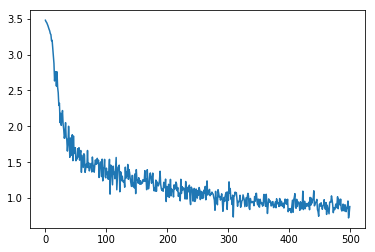

0.8821242451667786


In [29]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
print(losses[-1])

In [30]:
device='cuda'
torch.manual_seed(1)
encoder = S2SEncoder(vocab_size, embedding_dim, hidden_dim, num_layers)
decoder = S2SAttnDecoder(vocab_size, embedding_dim, hidden_dim, num_layers)
crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

encoder.to(device)
decoder.to(device)

losses = []
for i in range(500):
    X, Y, xl, yl = dummy_batch(batch_size, vocab_size, sequence_length)
    opt.zero_grad()
    out = s2s_feedprevious(encoder, decoder, X, Y, xl, yl, device).transpose(2,1)
    loss = crit(out, Y.to(device))
    losses.append(loss.item())
    loss.backward()
    opt.step()

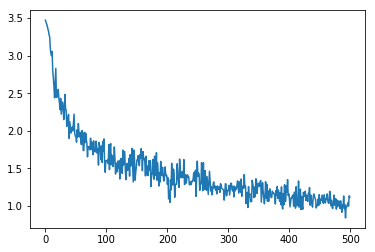

1.1142252683639526


In [31]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
print(losses[-1])